In [ ]:
#
# Based on the SEIR-HCD model code from kaggle, I have added the online data for the world,
# one can choose which country they want, model to use and the date to use as initial start day
#

In [ ]:
%reset

In [1]:
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13,
         'axes.labelweight':'bold',
          'legend.fontsize': 13,
         'figure.max_open_warning': 0}
         
plt.rcParams.update(params)

In [1]:
from datetime import datetime, timedelta
import os
from pathlib import Path

import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
    
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

from PIL import Image

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import plotly.io as pio
pio.renderers.default = 'colab'

Parameters used in the model
R_t = reproduction number at time t. Typical 3.6* at t=0

Transition times

- T_inc = average incubation period. Typical 5.6* days
- T_inf = average infectious period. Typical 2.9 days
- T_hosp = average time a patient is in hospital before either recovering or becoming critical. Typical 4 days
- T_crit = average time a patient is in a critical state (either recover or die). Typical 14 days

Fractions These constants are likely to be age specific (hence the subscript a):

- m_a = fraction of infections that are asymptomatic or mild. Assumed 80% (i.e. 20% severe)
- c_a = fraction of severe cases that turn critical. Assumed 10%
- f_a = fraction of critical cases that are fatal. Assumed 30%
- *Averages taken from https://www.kaggle.com/covid-19-contributions

In [3]:
# Susceptible equation
def dS_dt(S, I, R_t, t_inf):
    return -(R_t / t_inf) * I * S


# Exposed equation
def dE_dt(S, E, I, R_t, t_inf, t_inc):
    return (R_t / t_inf) * I * S - (E / t_inc)


# Infected equation
def dI_dt(I, E, t_inc, t_inf):
    return (E / t_inc) - (I / t_inf)


# Hospialized equation
def dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a):
    return ((1 - m_a) * (I / t_inf)) + ((1 - f_a) * C / t_crit) - (H / t_hosp)


# Critical equation
def dC_dt(H, C, t_hosp, t_crit, c_a):
    return (c_a * H / t_hosp) - (C / t_crit)


# Recovered equation
def dR_dt(I, H, t_inf, t_hosp, m_a, c_a):
    return (m_a * I / t_inf) + (1 - c_a) * (H / t_hosp)


# Deaths equation
def dD_dt(C, t_crit, f_a):
    return f_a * C / t_crit


def SEIR_HCD_model(t, y, R_t, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
    """

    :param t: Time step for solve_ivp
    :param y: Previous solution or initial values
    :param R_t: Reproduction number
    :param t_inc: Average incubation period. Default 5.2 days
    :param t_inf: Average infectious period. Default 2.9 days
    :param t_hosp: Average time a patient is in hospital before either recovering or becoming critical. Default 4 days
    :param t_crit: Average time a patient is in a critical state (either recover or die). Default 14 days
    :param m_a: Fraction of infections that are asymptomatic or mild. Default 0.8
    :param c_a: Fraction of severe cases that turn critical. Default 0.1
    :param f_a: Fraction of critical cases that are fatal. Default 0.3
    :return:
    """
    if callable(R_t):
        reprod = R_t(t)
    else:
        reprod = R_t
        
    S, E, I, R, H, C, D = y
    
    S_out = dS_dt(S, I, reprod, t_inf)
    E_out = dE_dt(S, E, I, reprod, t_inf, t_inc)
    I_out = dI_dt(I, E, t_inc, t_inf)
    R_out = dR_dt(I, H, t_inf, t_hosp, m_a, c_a)
    H_out = dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a)
    C_out = dC_dt(H, C, t_hosp, t_crit, c_a)
    D_out = dD_dt(C, t_crit, f_a)
    
    return [S_out, E_out, I_out, R_out, H_out, C_out, D_out]

In [4]:
def plot_model(solution, TotalPopulation, ICUHospital, title='SEIR+HCD model'):
    
    if TotalPopulation > 0:
        
        Population = True
        sus, exp, inf, rec, hosp, crit, death = solution.y*TotalPopulation
        cases = inf + rec + hosp + crit + death
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
        fig.suptitle(title)

        ax1.plot(sus, 'tab:blue', label='Susceptible');
        ax1.plot(exp, 'tab:orange', label='Exposed');
        ax1.plot(inf, 'tab:red', label='Infected');
        ax1.plot(rec, 'tab:green', label='Recovered');
        ax1.plot(hosp, 'tab:purple', label='Hospitalised');
        ax1.plot(crit, 'tab:brown', label='Critical');
        ax1.plot(death, 'tab:cyan', label='Deceased');
        ax1.hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(sus),linestyles='dashed',
                   label="Mean ICU beds")

        y1 = ICUHospital[1][0]
        y2 = ICUHospital[1][1]
        ax1.axhspan(y1, y2, facecolor='k', alpha=0.5)
        #ax1.fill_between(len(sus), y1,y2,alpha=0.5)
        
        ax1.semilogy()

        ax1.set_xlabel("Days", fontsize=10);
        ax1.legend(loc='best');

        ax2.plot(cases, 'tab:red', label='Cases');    
        ax2.set_xlabel("Days", fontsize=10);
        ax2.semilogy()

        ax3 = ax2.twinx()
        ax3.plot(death, 'tab:cyan', label='Deceased');    
        ax3.set_xlabel("Days", fontsize=10);
        ax3.semilogy()

        ax1.set_ylabel("No of population", fontsize=10);
        ax2.set_ylabel("No of population (Cases)", fontsize=10, color='tab:red');
        ax3.set_ylabel("No of population (Fatalities)", fontsize=10, color='tab:cyan');
        
    else:
        Population = False
        sus, exp, inf, rec, hosp, crit, death = solution.y
        cases = inf + rec + hosp + crit + death
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
        fig.suptitle(title)

        ax1.plot(sus, 'tab:blue', label='Susceptible');
        ax1.plot(exp, 'tab:orange', label='Exposed');
        ax1.plot(inf, 'tab:red', label='Infected');
        ax1.plot(rec, 'tab:green', label='Recovered');
        ax1.plot(hosp, 'tab:purple', label='Hospitalised');
        ax1.plot(crit, 'tab:brown', label='Critical');
        ax1.plot(death, 'tab:cyan', label='Deceased');
        #ax1.hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(sus),linestyles='dashed',
        #           label="Mean ICU beds")
        #y1 = ICUHospital[1][0]
        #y2 = ICUHospital[1][1]
        #ax1.axhspan(y1, y2, facecolor='k', alpha=0.5)
        
        ax1.set_xlabel("Days", fontsize=10);
        ax1.legend(loc='best');

        ax2.plot(cases, 'tab:red', label='Cases');    
        ax2.set_xlabel("Days", fontsize=10);

        ax3 = ax2.twinx()
        ax3.plot(death, 'tab:cyan', label='Deceased');    
        ax3.set_xlabel("Days", fontsize=10);
        
        ax1.set_ylabel("Fraction of population", fontsize=10);
        ax2.set_ylabel("Fraction of population (Cases)", fontsize=10, color='tab:red');
        ax3.set_ylabel("Fraction of population (Fatalities)", fontsize=10, color='tab:cyan');
        


    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125),ncol=3, fancybox=True, shadow=True)

# Data for SA

In [5]:
SAPopulation = 59156682
DateLockDownStart = '2020-03-27'

In [6]:
ToUpdate = input("Do we update datasets [y/n] ")

Do we update datasets [y/n] y


In [7]:
## Hospital data

In [8]:
def get_sa_hospital(ToUpdate):
    if ToUpdate.lower()=='y':
        url= "https://raw.githubusercontent.com/dsfsi/covid19za/Hospital_Data/data/health_system_za_public_hospitals_extended_details.csv"
        HospitalDf = pd.read_csv(wget.download(url))

    HospitalWithICU = HospitalDf.loc[np.where(HospitalDf.speciality_services.str.contains('intensive care') == True)]

    print(f"Mean Capacity \n{HospitalWithICU[['minimum_capacity','maximum_capacity']].mean()} \n Total Capacity \n{HospitalWithICU[['minimum_capacity','maximum_capacity']].sum()}")
    
    return(HospitalWithICU[['minimum_capacity','maximum_capacity']].mean(),
          HospitalWithICU[['minimum_capacity','maximum_capacity']].sum())

In [9]:
SAHospital = get_sa_hospital('y')

Mean Capacity 
minimum_capacity    371.428571
maximum_capacity    771.428571
dtype: float64 
 Total Capacity 
minimum_capacity     7800.0
maximum_capacity    16200.0
dtype: float64


In [10]:
MeanTotalBed = np.mean([SAHospital[1][0],SAHospital[1][1]])

# Getting daily data for the world 

In [11]:
ToUpdate = input("To update COVID-19 csv data [y/n]")

To update COVID-19 csv data [y/n]y


In [12]:
def get_world_dataframe(ToUpdate):
    #
    # data from https://www.worldometers.info/coronavirus/country/south-africa/
    #
    # Based on current data for e.g. SA
    #
    ### Include the data to extract the stats for particular country 
    ### Put country's params in a dict ?
    #
    if ToUpdate.lower()=='y':
        print("Updating csv")
        url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" 
        Confirmed_data = pd.read_csv(wget.download(url))
        
        url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
        Death_data = pd.read_csv(wget.download(url))

        url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series//time_series_covid19_recovered_global.csv"
        Recovered_data = pd.read_csv(wget.download(url))

    else:
        print("Will be loading local dataset")
        Globfilename = "/Users/nadeem/GitHub/COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
        Confirmed_data = pd.read_csv(Globfilename)

        Deathfilename = "/Users/nadeem/GitHub/COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
        Death_data = pd.read_csv(Deathfilename)

        Deathfilename = "/Users/nadeem/GitHub/COVID-19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
        Recovered_data = pd.read_csv(Deathfilename)


    dates = Confirmed_data.columns[4:]
    Confirmed_data_long = Confirmed_data.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                                value_vars=dates, var_name='Date', value_name='Confirmed')
    Confirmed_data_long["Date"] = pd.to_datetime(Confirmed_data_long.Date)
    Confirmed_data_long.index = Confirmed_data_long["Date"]

    Confirmed_data_long.columns

    dates = Death_data.columns[4:]
    Death_data_long = Death_data.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                                value_vars=dates, var_name='Date', value_name='Dead')
    Death_data_long["Date"] = pd.to_datetime(Death_data_long.Date)
    Death_data_long.index = Death_data_long["Date"]

    dates = Recovered_data.columns[4:]
    Recovered_data_long = Recovered_data.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                                value_vars=dates, var_name='Date', value_name='Recovered')
    Recovered_data_long["Date"] = pd.to_datetime(Recovered_data_long.Date)
    Recovered_data_long.index = Recovered_data_long["Date"]



    df = pd.concat([Confirmed_data_long,Recovered_data_long,Death_data_long],join='outer')
    df.columns = ['Province/State', 'Country/Region', 'Lat', 'Long', 'DateReported', 'Confirmed','Recovered', 'Dead']
    
    return(Confirmed_data_long,Death_data_long, Recovered_data_long,df)

In [13]:
ConfirmedDf, DeadDf, RecoveredDf, df = get_world_dataframe('y')

Updating csv


In [14]:
len(df)

82320

In [15]:
ToPlot = False

In [16]:
countries = df["Country/Region"].unique()
df_by_date = df.groupby("Date").sum()
last_day = df_by_date.iloc[-1]
pre_last_day = df_by_date.iloc[-2]
total_infected = last_day["Confirmed"]
total_deaths = last_day["Dead"]
total_recoveries = pre_last_day["Recovered"]

infected_timeline = df_by_date["Confirmed"]
death_timeline = df_by_date["Dead"]
recovery_timeline = df_by_date["Recovered"][:-1]

print("[!] GENERAL STATISTICS")
print("[-] Number of infected countries: {}".format(len(countries)))
print("[-] Total number of infected: {}".format(total_infected))

print("[-] Total number of deaths: {}".format(total_deaths))

print("[-] Total number of recoveries: {}".format(total_recoveries))

if ToPlot:
    infected_timeline.iplot()
    death_timeline.iplot()
    recovery_timeline.iplot()

[!] GENERAL STATISTICS
[-] Number of infected countries: 187
[-] Total number of infected: 3662691.0
[-] Total number of deaths: 257239.0
[-] Total number of recoveries: 1162724.0


## Plotting for South Africa here

In [17]:
DfSA = df[df['Country/Region'] == 'South Africa']
SA_last_date = DfSA.index[-1].date().strftime("%Y-%m-%d")

SA_by_date = DfSA.groupby("DateReported").sum()
SA_last_day = DfSA.iloc[-1]
SA_pre_last_day = DfSA.iloc[-2]
SAtotal_infected = DfSA[DfSA["DateReported"]== SA_last_date]["Confirmed"][0]
SAtotal_deaths = DfSA[DfSA["DateReported"]== SA_last_date]["Dead"][2]
SAtotal_recoveries = DfSA[DfSA["DateReported"]== SA_last_date]["Recovered"][1]

SAinfected_timeline = SA_by_date["Confirmed"]
SAdeath_timeline = SA_by_date["Dead"]
SArecovery_timeline = SA_by_date["Recovered"][:-1]



print(f"[!] GENERAL STATISTICS as at {SA_last_date}")
#print("[-] Number of infected countries: {}".format(len(countries)))
print("[-] Total number of infected: {}".format(SAtotal_infected))

print("[-] Total number of deaths: {}".format(SAtotal_deaths))

print("[-] Total number of recoveries: {}".format(SAtotal_recoveries))

if ToPlot:
    SAdeath_timeline.iplot(interpolation="spline")
    SAinfected_timeline.iplot(interpolation="spline")
    SArecovery_timeline.iplot(interpolation="spline")

[!] GENERAL STATISTICS as at 2020-05-05
[-] Total number of infected: 7572.0
[-] Total number of deaths: 148.0
[-] Total number of recoveries: 2746.0


# Put fit to the various curves

In [18]:
# Calculate the doubling days

In [19]:
#SAinfected_timeline

## Getting SA province data 

In [20]:
ToUpdateSA = input("To update sa dataset [y/n] ")

To update sa dataset [y/n] y


In [21]:

if ToUpdateSA.lower() =='y':
    print("updating data")
    SAURL = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
    SAProvinConfirmed = pd.read_csv(wget.download(SAURL))
else:
    print("reading local file - Please check date")
    ParamEstimates = pd.read_csv("covid19za_provincial_cumulative_timeline_confirmed.csv")

updating data


In [22]:
SAProvinConfirmed.drop(columns='YYYYMMDD', inplace = True)

In [23]:
SAProvinConfirmed["date"] = pd.to_datetime(SAProvinConfirmed.date, format='%d-%m-%Y')

SAProvinConfirmed.index = SAProvinConfirmed["date"]

SAProvinConfirmed.drop(columns='date', inplace = True)

SAProvinConfirmed = SAProvinConfirmed.rename(columns={'total': 'Confirmed'})

SAProvinConfirmed.drop(columns='source', inplace = True)

SAProvinConfirmed.tail()

,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,Confirmed
date,,,,,,,,,,,
2020-05-01,691.0,118.0,1507.0,1006.0,34.0,35.0,18.0,35.0,2507.0,0.0,5951
2020-05-02,732.0,121.0,1598.0,1051.0,36.0,40.0,23.0,35.0,2700.0,0.0,6336
2020-05-03,774.0,122.0,1624.0,1076.0,37.0,46.0,24.0,36.0,3044.0,0.0,6783
2020-05-04,814.0,125.0,1651.0,1106.0,39.0,53.0,25.0,35.0,3362.0,0.0,7220
2020-05-05,838.0,128.0,1697.0,1142.0,40.0,57.0,26.0,35.0,3609.0,0.0,7572


In [24]:
#
# Validation test to check world dataset and local dataset aggrees on selected date
#

MyDate = input('Date for checking dataset YYYY-MM-DD: ')

if SAtotal_infected == SAProvinConfirmed[(SAProvinConfirmed.index == MyDate)].Confirmed.values:
    print(f"No prob in dataset for {MyDate}")
else:
    print("Maybe some data issue")

Date for start of projection YYYY-MM-DD: 2020-05-05
No prob in dataset for 2020-05-05


In [ ]:
SAProvinConfirmed.iplot(title=f"SA provincial distribution as at {SAProvinConfirmed.index[-1].date()}")

In [25]:
# Doing some prediction using fbprophet

In [26]:
def prophet_forecast(mydate,mydata):
    '''
    This function will use fbprophet to forecast the cases in 30 days
    Input: Date and ycolumn
    Output: returns a forecast dataframe
    '''
    from fbprophet import Prophet
    from fbprophet.plot import plot_plotly, add_changepoints_to_plot

    data = pd.DataFrame({'ds': mydate, 'y': mydata})

    prop=Prophet(changepoint_range=0.9)
    prop.fit(data)
    future=prop.make_future_dataframe(periods=30)
    prop_forecast=prop.predict(future)
    forecast = prop_forecast[['ds','yhat']].tail(30)

    fig = plot_plotly(prop, prop_forecast)
    fig = prop.plot(prop_forecast,xlabel='Date',ylabel='No of Cases')
    
    return(prop_forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


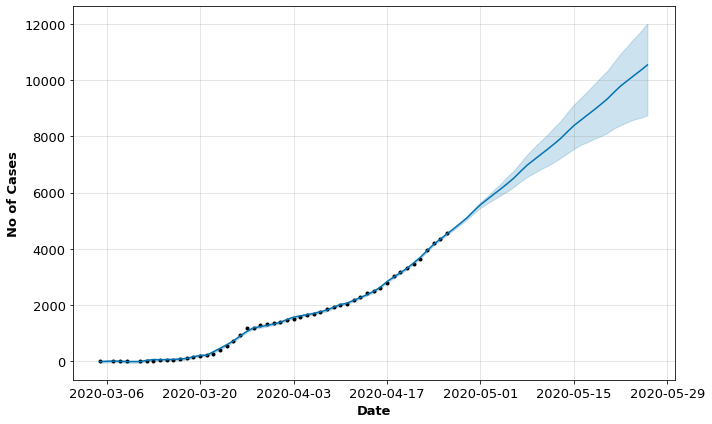

In [27]:
DateToUse = "2020-04-27"
mydata = SAProvinConfirmed[SAProvinConfirmed.index<DateToUse]['Confirmed'].values.tolist()
mydate = SAProvinConfirmed[SAProvinConfirmed.index<DateToUse].index.values

ProphetDF = prophet_forecast(mydate,mydata)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


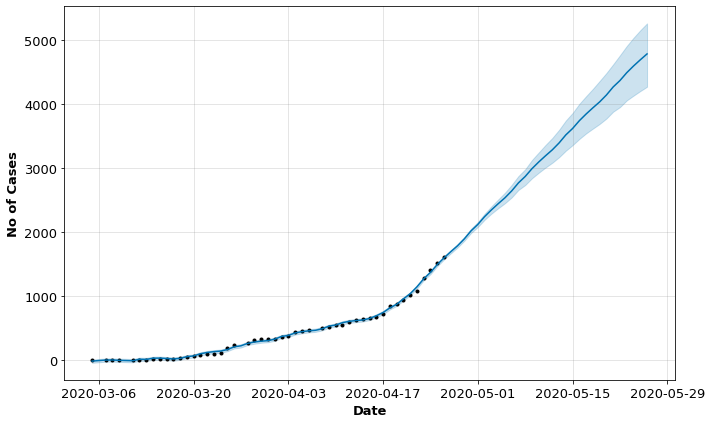

In [28]:

mydata = SAProvinConfirmed[SAProvinConfirmed.index<DateToUse]['WC'].values.tolist()
mydate = SAProvinConfirmed[SAProvinConfirmed.index<DateToUse].index.values
ProphetDFWC = prophet_forecast(mydate,mydata)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


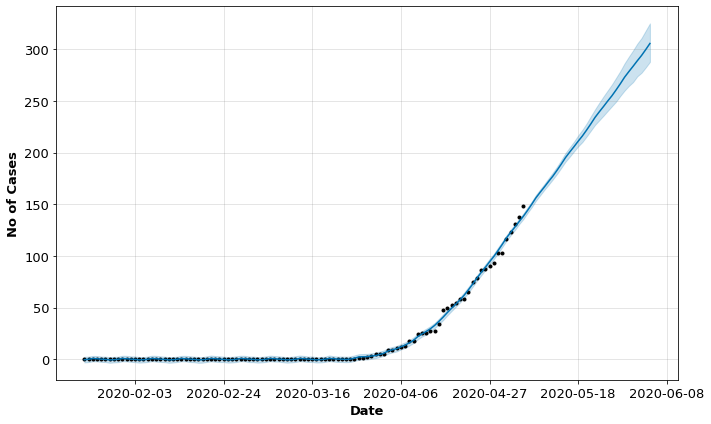

In [172]:
mydata = SAdeath_timeline.values.tolist()
mydate = SAdeath_timeline.index.values
ProphetDFDeath = prophet_forecast(mydate,mydata)

# Calculating value of R_0

In [29]:
#
# In order to calculate R0 we can adapt this https://en.wikipedia.org/wiki/Basic_reproduction_number#Estimation_methods
#

In [30]:
from scipy.optimize import curve_fit

In [173]:
def get_R0(DFSeries):
    
    def fit_expo(x,y):   
        logParams   = np.polyfit(x, np.log(y), 1,w=np.sqrt(y))
        initParams  = (np.exp(logParams[1]), logParams[0])
        params      = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y, p0=initParams)    
        return params[0],params[1],initParams
    #
    StartDate = datetime.strptime('Apr 9 2020', '%b %d %Y')
    #
    #StartDate = DFSeries.index[0]

    TimeDelta = (DFSeries.index - StartDate)
    x = list(TimeDelta.days)
    y = list(DFSeries.values)

    LogisticFit = fit_expo(x,y)

    a = LogisticFit[0][0]
    b = LogisticFit[0][1] # This is also K
    print(a,b)
    
    T_d = np.log(2)/b # dooubling rate

    tau = 5.1
    
    R_0 = np.exp(b*tau)

    print(f"R_0 calculated: {R_0}")
    
    return(R_0)

In [32]:
#
# Calculating R_) for all provinces
#

In [189]:
#
# To calculate R_0 we need to take data before the lockdown, where we have a uniform mixing
#
R0_values = []
for i in SAProvinConfirmed.columns:
    
    ToFit = SAProvinConfirmed[SAProvinConfirmed.index < datetime.strptime('Mar 27 2020', '%b %d %Y') ][i]
    #get_R0(ToFit)
    R0_values.append((i,get_R0(ToFit)))

nan nan
R_0 calculated: nan
nan nan
R_0 calculated: nan
nan nan
R_0 calculated: nan
5383.975019431702 0.26678287623178953
R_0 calculated: 3.8985031383507165
nan nan
R_0 calculated: nan
nan nan
R_0 calculated: nan
nan nan
R_0 calculated: nan
nan nan
R_0 calculated: nan
nan nan
R_0 calculated: nan
nan nan
R_0 calculated: nan
41212.117886008666 0.2710353611091105
R_0 calculated: 3.9839761037771657


<ipython-input-173-8c04ad70df24>:4: RuntimeWarning:

divide by zero encountered in log

/Users/nadeem/py3_kernel/lib/python3.8/site-packages/numpy/lib/polynomial.py:626: RuntimeWarning:

invalid value encountered in multiply

/Users/nadeem/py3_kernel/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning:

Covariance of the parameters could not be estimated



In [296]:
R0_values

[('EC', nan),
 ('FS', nan),
 ('GP', nan),
 ('KZN', 3.8985031383507165),
 ('LP', nan),
 ('MP', nan),
 ('NC', nan),
 ('NW', nan),
 ('WC', nan),
 ('UNKNOWN', nan),
 ('Confirmed', 3.9839761037771657)]

In [195]:
ToFit = SAProvinConfirmed[SAProvinConfirmed.index < datetime.strptime('Mar 27 2020', '%b %d %Y') ]['Confirmed']

In [267]:
R0_SA = get_R0(ToFit)

41212.117886008666 0.2710353611091105
R_0 calculated: 3.9839761037771657


In [268]:
def f_decay(x,a,b):
    return a*np.exp(b*x)

In [269]:
#
# Since some province had a missing data on 
#
#StartDate = datetime.strptime('Mar 27 2020', '%b %d %Y')
StartDate = SAProvinConfirmed.index[0]
#
#StartDate = DFSeries.index[0]

TimeDelta = (ToFit.index - StartDate)
x = list(TimeDelta.days)
y = list(ToFit.values)

Text(0, 0.5, 'No of confirmed cases')

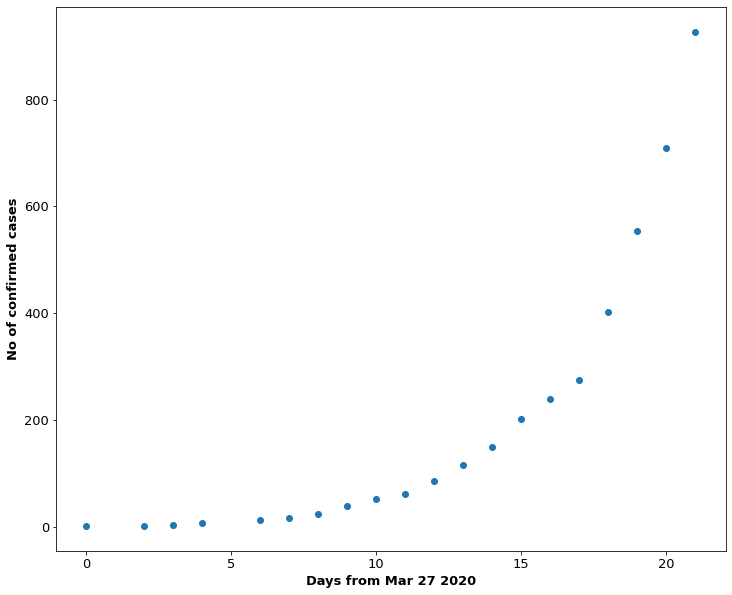

In [270]:
plt.plot(x,y,'o')
plt.xlabel("Days from Mar 27 2020")
plt.ylabel("No of confirmed cases")

In [271]:
vGuess = [40000, 0.2]
sError = 0.1
nTrials = 10000
#aFitPars = np.array([])

In [272]:
aFitSameTimes=np.array([])

for iTrial in range(nTrials):

    yGen = 41212.*np.exp(0.2*np.array(x))  # Same measured times this time!
    yTrial = yGen + np.random.normal(scale=sError,size=np.size(yGen))
    #
    # We use a try/except clause to catch pathologies
    #
    try:
        vTrial, aCova = curve_fit(f_decay,x,yTrial,vGuess)
    except:
        dumdum=1
        continue  # This moves us to the next loop without stacking.
    #    
    # Here follows the syntax for stacking the trial onto the running sample:
    #
    if np.size(aFitSameTimes) < 1:
        aFitSameTimes=np.copy(vTrial)
    else:
        aFitSameTimes = np.vstack(( aFitSameTimes, vTrial ))

In [273]:
np.shape(aFitSameTimes)

(10000, 2)

Text(0.5, 1.0, 'Same measurement times each trial')

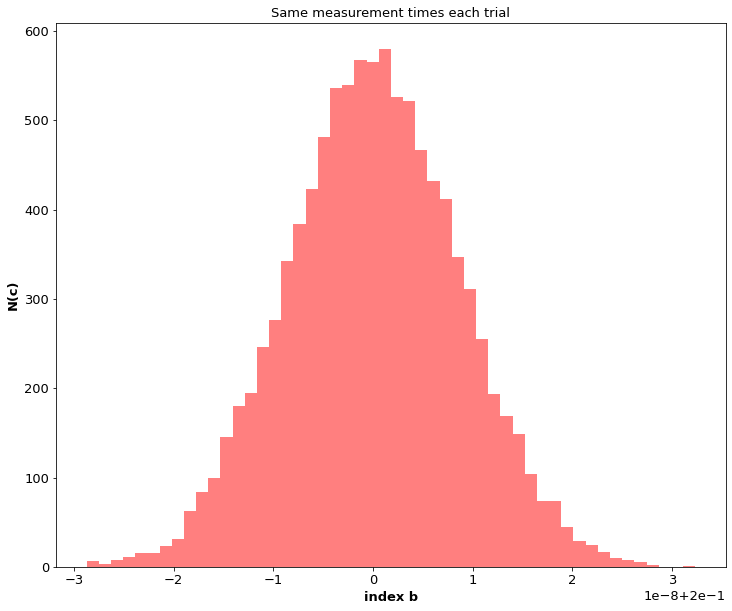

In [274]:
plt.hist(aFitSameTimes[:,1],bins=50, alpha=0.5,color='r')
plt.xlabel('index b')
plt.ylabel('N(c)')
plt.title('Same measurement times each trial')

Text(0, 0.5, 'Power-law index b')

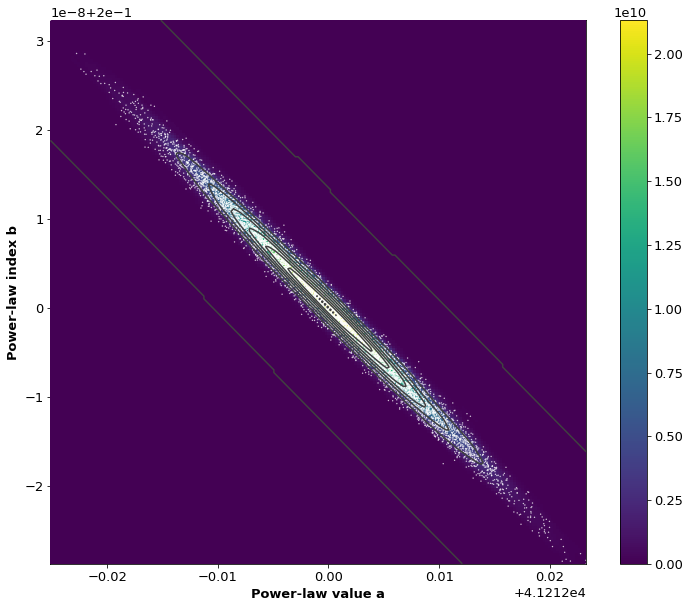

In [275]:

from scipy.stats import kde
x,y=aFitSameTimes.T

# Use a kernel density estimator to produce local-counts in this space, and grid them to plot.
k = kde.gaussian_kde(aFitSameTimes.T)
nbins=200
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Show the density
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), zorder=3)
plt.colorbar()

# Show the datapoints on top of this, and also the contours. "zorder" sets the vertical order in the plot.
plt.scatter(aFitSameTimes[:,0], aFitSameTimes[:,1], c='w', s=2, zorder=15, edgecolor='none',alpha=0.75)
plt.contour(xi,yi,zi.reshape(xi.shape), zorder=25, colors='0.25')


#P.ylim(-1.45,-0.55)
#P.xlim(1.25,1.80)
plt.xlabel('Power-law value a')
plt.ylabel('Power-law index b')

In [276]:
print(np.median(aFitSameTimes[:,1]))
print(np.std(aFitSameTimes[:,1]))

0.20000000008693822
8.58669932917086e-09


In [277]:
tau = 5.1
b = np.median(aFitSameTimes[:,1])
R0_SA = np.exp(b*tau)
print(f"Doubling time = {np.log(2)/b:.3} days and R_0 = {R0_SA}")

Doubling time = 3.47 days and R_0 = 2.7731947651938906


In [218]:
#
# Updating some values for SA
#

In [293]:
SA_model ={
        "R_0" : R0_SA,#new_df[new_df['Country/State/UT'] == 'Confirmed']['R0'].values[0],
        "R_t" : R0_SA*1.2,#0.7,
        "t_inc" : 5.1, # Li et al. (1) has latency phase/incubation time of 5.2 days (95% CI [4.1, 7]).
        "t_inf" : 6.5,
        "t_hosp" : 4,
        "t_crit" : 14,
        "m_a" : 0.8,
        "c_a" : 0.1,
        "f_a" : 0.3
}

# Parameters estimates

## Location of various parameters as per Midas 

### https://github.com/midas-network/COVID-19/blob/master/parameter_estimates/2019_novel_coronavirus/estimates.csv
### Check above link for updated parameters

Paramters used:

- Average incubation period, t_inc
- Average infection period, t_inf
- Average hospitalization period, t_hosp
- Average critital period, t_crit
- The fraction of mild/asymptomatic cases, m_a
- The fraction of severe cases that turn critical, c_a
- The fraction of critical cases that result in a fatality, f_a
- Reproduction number, R_0 or R_t

In [47]:
#
# This is not working properly 
#

ToUpdate = input("To update data [y/n] ")

url = "https://raw.githubusercontent.com/midas-network/COVID-19/master/parameter_estimates/2019_novel_coronavirus/estimates.csv"
if ToUpdate.lower()=='y':
    ParamEstimates = pd.read_csv(wget.download(url))
else:
    ParamEstimates = pd.read_csv("estimates.csv")

To update data [y/n] y


In [48]:
ParamEstimates.columns

Index(['id', 'peer_review', 'peer_review_location', 'name', 'abbreviation',
       'units', 'country', 'location_name', 'location_type', 'start_date',
       'end_date', 'value_type', 'value', 'uncertainty_type', 'lower_bound',
       'upper_bound', 'population', 'age_range', 'method_description',
       'data_description', 'data_URL', 'date_publication', 'title_publication',
       'type_publication', 'authors', 'publication_URL', 'entry_date',
       'entry_person', 'entry_email'],
      dtype='object')

In [49]:
ParamEstimates['peer_review'].unique()

array([nan, 'positive', 'negative', 'postitive'], dtype=object)

In [50]:
R0_nopeer = [np.float(ParamEstimates[(ParamEstimates['abbreviation'] == "R0")]['lower_bound'].values[0]),
      np.float(ParamEstimates[(ParamEstimates['abbreviation'] == "R0")]['upper_bound'].values[0]),
      np.float(ParamEstimates[(ParamEstimates['abbreviation'] == "R0")]['value'].values[0])]

R0_peer = [ParamEstimates[(ParamEstimates['abbreviation'] == "R0") & 
               (ParamEstimates['peer_review'] == "positive")]['lower_bound'].values,
           ParamEstimates[(ParamEstimates['abbreviation'] == "R0") & 
               (ParamEstimates['peer_review'] == "positive")]['upper_bound'].values,
           ParamEstimates[(ParamEstimates['abbreviation'] == "R0") & 
               (ParamEstimates['peer_review'] == "positive")]['value'].values]

if np.array(R0_peer).size == 0:
    R_0 = np.mean(np.array(R0_nopeer))
    print(f"Array is empty, will use non-peer reviewed {R_0}")
else:
    
    R_0 = float(R0_peer[-1][1])
    print(f"Using peer-reviewed mean R_0: {R_0}")

Using peer-reviewed mean R_0: 2.24


In [51]:
Rt_nopeer = [np.float(ParamEstimates[(ParamEstimates['abbreviation'] == "Rt")]['lower_bound'].values[0]),
      np.float(ParamEstimates[(ParamEstimates['abbreviation'] == "Rt")]['upper_bound'].values[0]),
      np.float(ParamEstimates[(ParamEstimates['abbreviation'] == "Rt")]['value'].values[0])]

Rt_peer = [ParamEstimates[(ParamEstimates['abbreviation'] == "Rt") & 
               (ParamEstimates['peer_review'] == "positive")]['lower_bound'].values,
           ParamEstimates[(ParamEstimates['abbreviation'] == "Rt") & 
               (ParamEstimates['peer_review'] == "positive")]['upper_bound'].values,
           ParamEstimates[(ParamEstimates['abbreviation'] == "Rt") & 
               (ParamEstimates['peer_review'] == "positive")]['value'].values]

if np.array(Rt_peer).size == 0:
    R_t = np.mean(np.array(Rt_nopeer))
    print(f"Array is empty, will use non-peer reviewed Rt {R_t:0.2}")
else:
    R_t = float(Rt_peer[-1][1])
    print(f"Using peer-reviewed mean R_t: {R_t}")

Array is empty, will use non-peer reviewed Rt 0.87


In [52]:
tinc_nopeer = [np.float(ParamEstimates[(ParamEstimates['name'] == "incubation period")]['lower_bound'].values[0]),
      np.float(ParamEstimates[(ParamEstimates['name'] == "incubation period")]['upper_bound'].values[0]),
      np.float(ParamEstimates[(ParamEstimates['name'] == "incubation period")]['value'].values[0])]

tinc_peer = [ParamEstimates[(ParamEstimates['name'] == "incubation period") & 
               (ParamEstimates['peer_review'] == "positive")]['lower_bound'].values,
           ParamEstimates[(ParamEstimates['name'] == "incubation period") & 
               (ParamEstimates['peer_review'] == "positive")]['upper_bound'].values,
           ParamEstimates[(ParamEstimates['name'] == "incubation period") & 
               (ParamEstimates['peer_review'] == "positive")]['value'].values]

if np.array(tinc_peer).size == 0:
    print(f"Array is empty, will use tinc_nopeer ")
    tinc = np.mean(np.array(tinc_nopeer))
    print(t_inc)
else:

    t_inc = float(tinc_peer[-1][1])
    print(f"Using peer-reviewed mean t_inc: {t_inc}")

Using peer-reviewed mean t_inc: 4.2


In [53]:
beta_nopeer = [np.float(ParamEstimates[(ParamEstimates['abbreviation'] == "beta")]['lower_bound'].values[0]),
      np.float(ParamEstimates[(ParamEstimates['abbreviation'] == "beta")]['upper_bound'].values[0]),
      np.float(ParamEstimates[(ParamEstimates['abbreviation'] == "beta")]['value'].values[0])]

beta_peer = [ParamEstimates[(ParamEstimates['abbreviation'] == "beta") & 
               (ParamEstimates['peer_review'] == "positive")]['lower_bound'].values,
           ParamEstimates[(ParamEstimates['abbreviation'] == "beta") & 
               (ParamEstimates['peer_review'] == "positive")]['upper_bound'].values,
           ParamEstimates[(ParamEstimates['abbreviation'] == "beta") & 
               (ParamEstimates['peer_review'] == "positive")]['value'].values]

if np.array(beta_peer).size == 0:
    print(f"Array is empty, will use tinc_nopeer ")
    beta = np.mean(np.array(beta_nopeer))
    print(t_inc)
else:

    beta = float(beta_peer[-1][1])
    print(f"Using peer-reviewed mean beta: {beta}")

Using peer-reviewed mean beta: 0.52


In [54]:
Midas_model ={
    "R_0" : R_0,
    "R_t" : R_t, # since there is no peer reviewed R_t
    "t_inc" : t_inc,
    "t_inf" : 2.9,
    "t_hosp" : 4,
    "t_crit" : 14,
    "m_a" : 0.8,
    "c_a" : 0.1,
    "f_a" : 0.3
}

In [55]:
Midas_model

{'R_0': 2.24,
 'R_t': 0.8666666666666667,
 't_inc': 4.2,
 't_inf': 2.9,
 't_hosp': 4,
 't_crit': 14,
 'm_a': 0.8,
 'c_a': 0.1,
 'f_a': 0.3}

In [149]:
Imperial_model ={
        # use parameters from the Imperial paper (https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf)
        "R_0" : 2.4,
        "R_t" : 1.16,#0.7, # since there is no peer reviewed R_t
        "t_inc" : 5.1,
        "t_inf" : 6.5,
        "t_hosp" : 4,
        "t_crit" : 14,
        "m_a" : 0.8,
        "c_a" : 0.1,
        "f_a" : 0.3
}

In [57]:
Imperial_model

{'R_0': 2.4,
 'R_t': 1.16,
 't_inc': 5.1,
 't_inf': 6.5,
 't_hosp': 4,
 't_crit': 14,
 'm_a': 0.8,
 'c_a': 0.1,
 'f_a': 0.3}

In [58]:
Kaggle_model ={
        "R_0" : 3.6,
        "R_t" : 0.7,
        "t_inc" : 5.6,
        "t_inf" : 2.9,
        "t_hosp" : 4,
        "t_crit" : 14,
        "m_a" : 0.8,
        "c_a" : 0.1,
        "f_a" : 0.3
}

In [60]:
MyDate = input('Date for start of projection YYYY-MM-DD: ')

Date for start of projection YYYY-MM-DD: 2020-05-03


In [61]:
tmp = df[(df['DateReported'] == MyDate)]# & (df['Country/Region' == 'South Africa'])]

In [63]:
MyCountry = input("Enter country to Analyse e.g 'South Arica'")

Enter country to Analyse e.g 'South Arica'South Africa


In [64]:
tmp_by_date = tmp.groupby("DateReported").sum()

In [70]:
#
# Creating a dictionary to hold data for country selected
#
SADict = {
    "N" : SAPopulation,  # Population size
    "n_confirmed" : tmp[tmp['Country/Region'] == 'South Africa']['Confirmed'][0],
    "n_recovered" : tmp[tmp['Country/Region'] == 'South Africa']['Recovered'][1],
    "n_dead" : tmp[tmp['Country/Region'] == 'South Africa']['Dead'][2],
    "n_infected" : tmp[tmp['Country/Region'] == 'South Africa']['Confirmed'][0]-tmp[tmp['Country/Region'] == 'South Africa']['Recovered'][1],
    "n_exposed" : (tmp[tmp['Country/Region'] == 'South Africa']['Confirmed'][0]-tmp[tmp['Country/Region'] == 'South Africa']['Recovered'][1])*9 ,#thumbsuck
    "n_hosp" : 411,#from net as at 02-05-2020
    "n_crit" : 7
}

# Modelling starts here


## Model without intervention

In [286]:
def model_no_intervention(ModelName,model_days,MyCountry,MyCountryDict):
    
    if MyCountry == "South Africa":
        #print(f"Doing {MyCountry}")
        N = MyCountryDict['N']  # Population size
        n_infected = MyCountryDict['n_infected'] # total cases - recovered: 4793 - 1473
        n_exposed = MyCountryDict['n_exposed'] #thumbsuck
        n_recovered = MyCountryDict['n_recovered']
        n_hosp = MyCountryDict['n_hosp']
        n_crit = MyCountryDict['n_crit']
        n_dead = MyCountryDict['n_dead']
        
        max_days = model_days
        initial_state = [(N - n_infected)/N, n_exposed/N, n_infected/N, n_recovered/N, n_hosp/N, n_crit/N, n_dead/N]
    else:
        #print("Not doing my country..this is for cross checking")
        #N = int(input("Enter population size"))
        N = 100000  # Population size
        n_infected = 1
        # State at time = 0 for SEIR_HCD model
        # The numbers correspond to the number of people in each of the SEIRHCD compartments
        max_days = model_days
        initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
        
    # State at time = 0 for SEIR_HCD model
    # The numbers correspond to the number of people in each of the SEIRHCD compartments
    # number of people in each of the SEIRHCD compartments at start of simulation
    #initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
    #initial_state = [(N - n_infected)/N, n_exposed, n_infected/N, n_recovered/N, n_hosp/N, n_crit/N, n_dead/N]
    #
    # Put model as a list
    #
    
    args = (ModelName["R_0"], ModelName["t_inc"], ModelName["t_inf"], ModelName["t_hosp"], ModelName["t_crit"], 
            ModelName["m_a"], ModelName["c_a"], ModelName["f_a"])

    sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

    return(sol)

In [287]:
DaysToPredict = 250 #4 months

In [281]:
MyResultImperial = model_no_intervention(Imperial_model,DaysToPredict,MyCountry, SADict)

Maximum fatalities = 3.74e+05
Maximum starts to occur at 2020-07-14


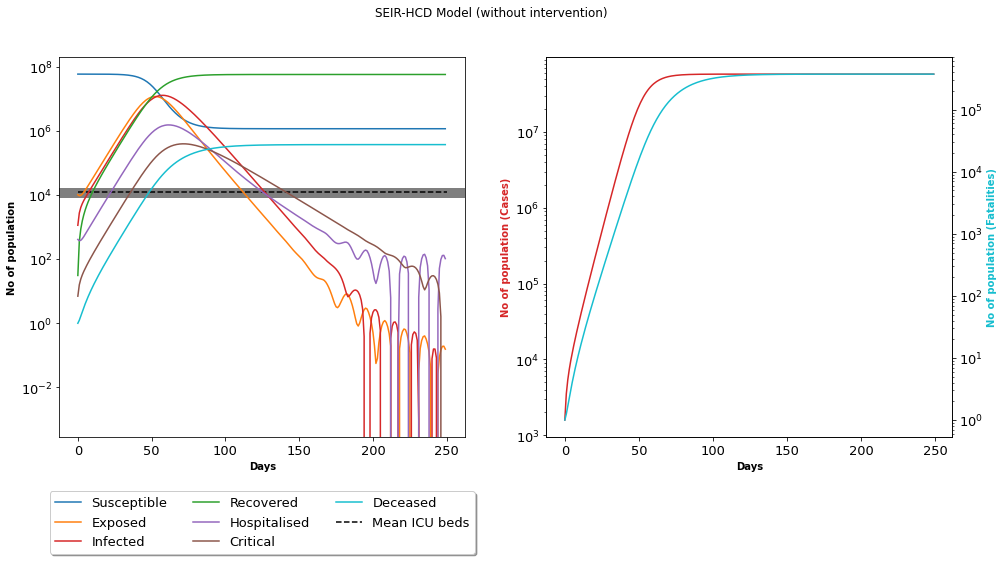

In [282]:
plot_model(MyResultImperial,SADict["N"], SAHospital,'SEIR-HCD Model (without intervention)')
print(f"Maximum fatalities = {np.max(MyResultImperial.y[-1])*SADict['N']:.3}")

max_dead = timedelta(**{'days': int(np.gradient(MyResultImperial.y[-1]).argmax())})
print(f"Maximum starts to occur at {(datetime.strptime(MyDate, '%Y-%m-%d')+timedelta(days=max_dead.days)).strftime('%Y-%m-%d')}")


Maximum fatalities = 3.74e+05
Maximum starts to occur at 2020-06-19


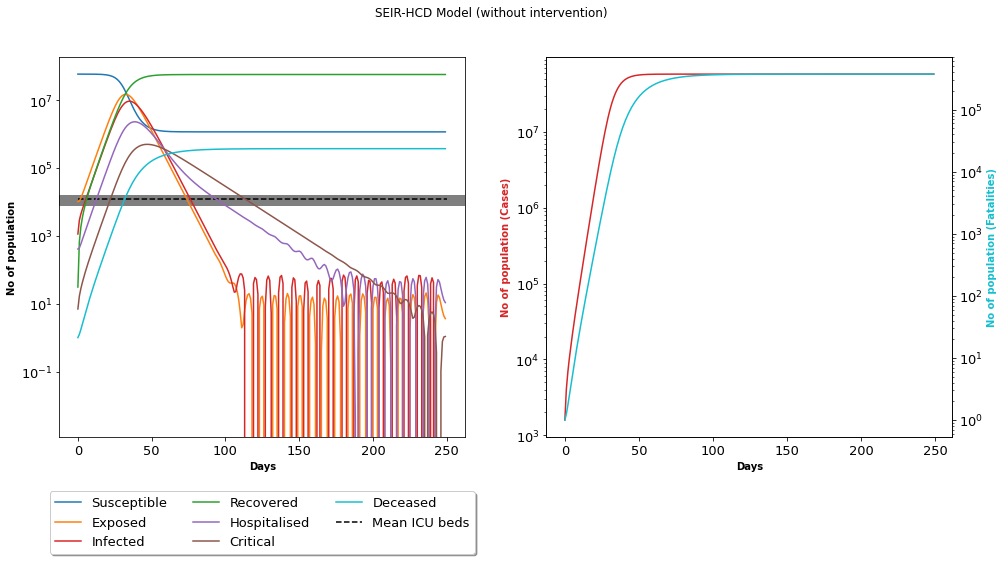

In [283]:
MyResultMidas = model_no_intervention(Midas_model,DaysToPredict,MyCountry, SADict)
plot_model(MyResultMidas,SADict["N"], SAHospital,'SEIR-HCD Model (without intervention)')
print(f"Maximum fatalities = {np.max(MyResultMidas.y[-1])*SADict['N']:.3}")

max_dead = timedelta(**{'days': int(np.gradient(MyResultMidas.y[-1]).argmax())})
print(f"Maximum starts to occur at {(datetime.strptime(MyDate, '%Y-%m-%d')+timedelta(days=max_dead.days)).strftime('%Y-%m-%d')}")


Maximum fatalities = 3.52e+05
Maximum starts to occur at 2020-08-29


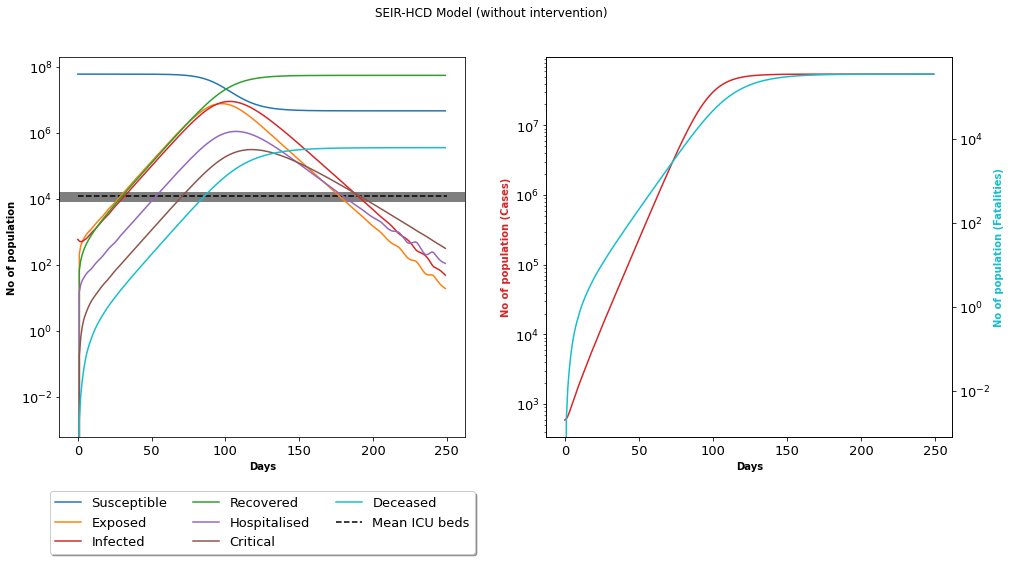

In [288]:
MyResultSA = model_no_intervention(SA_model,DaysToPredict,'lala', SADict)
plot_model(MyResultSA,SADict['N'], SAHospital,'SEIR-HCD Model (without intervention)')
print(f"Maximum fatalities = {np.max(MyResultSA.y[-1])*SADict['N']:.3}")

max_dead = timedelta(**{'days': int(np.gradient(MyResultSA.y[-1]).argmax())})
print(f"Maximum starts to occur at {(datetime.strptime(MyDate, '%Y-%m-%d')+timedelta(days=max_dead.days)).strftime('%Y-%m-%d')}")


# With intervention

In [289]:
def model_with_intervention(ModelName,model_days,MyCountry,MyCountryDict,LockDown):
    
    if MyCountry == "South Africa":
        print(f"Doing {MyCountry}")
        N = MyCountryDict['N']  # Population size
        n_infected = MyCountryDict['n_infected'] # total cases - recovered: 4793 - 1473
        n_exposed = n_infected*9 #thumbsuck
        n_recovered = MyCountryDict['n_recovered']
        n_hosp = 340
        n_crit = 7
        n_dead = MyCountryDict['n_dead']
        max_days = model_days
        initial_state = [(N - n_infected)/N, n_exposed/N, n_infected/N, n_recovered/N, n_hosp/N, n_crit/N, n_dead/N]
    else:
        print("Not doing my country..this is for cross checking")
        #N = int(input("Enter population size"))
        N = 100000  # Population size
        n_infected = 1
        # State at time = 0 for SEIR_HCD model
        # The numbers correspond to the number of people in each of the SEIRHCD compartments
        max_days = model_days
        initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]
        
        
    #R_0 = 3.6 # reproduction number without intervention
    #R_0 = R0.astype('float').mean()
    #R_t = 0.7  # reproduction number after intervention
    #R_t = 0.9 # singapore

    intervention_day = LockDown # day when lockdown start

    def time_varying_reproduction(t):
        if t > intervention_day:
            return ModelName["R_t"]
        else:
            return ModelName["R_0"]

    args = (time_varying_reproduction, ModelName["t_inc"], ModelName["t_inf"], ModelName["t_hosp"], 
            ModelName["t_crit"],ModelName["m_a"], ModelName["c_a"], ModelName["f_a"])

    sol2 = solve_ivp(SEIR_HCD_model, [0, model_days], initial_state, args=args, t_eval=np.arange(model_days))
    return(sol2)

In [290]:
LockDown = 25 # days

Doing South Africa
Maximum fatalities = 2.49e+05
Maximum starts to occur at 2020-08-28


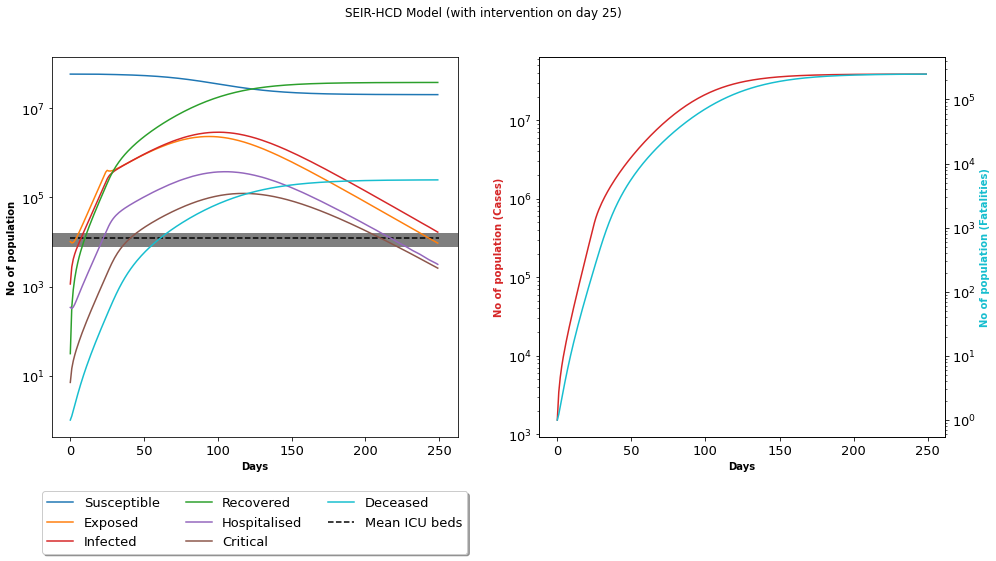

In [228]:

MyResultImperial2 = model_with_intervention(Imperial_model,DaysToPredict,MyCountry, SADict,LockDown)

plot_model(MyResultImperial2,SADict["N"], SAHospital,f"SEIR-HCD Model (with intervention on day {LockDown})")
print(f"Maximum fatalities = {np.max(MyResultImperial2.y[-1])*SADict['N']:.3}")

max_dead = timedelta(**{'days': int(np.gradient(MyResultImperial2.y[-1]).argmax())})
print(f"Maximum starts to occur at {(datetime.strptime(MyDate, '%Y-%m-%d')+timedelta(days=max_dead.days)).strftime('%Y-%m-%d')}")


Doing South Africa
Maximum fatalities = 2.82e+05
Maximum starts to occur at 2020-06-22


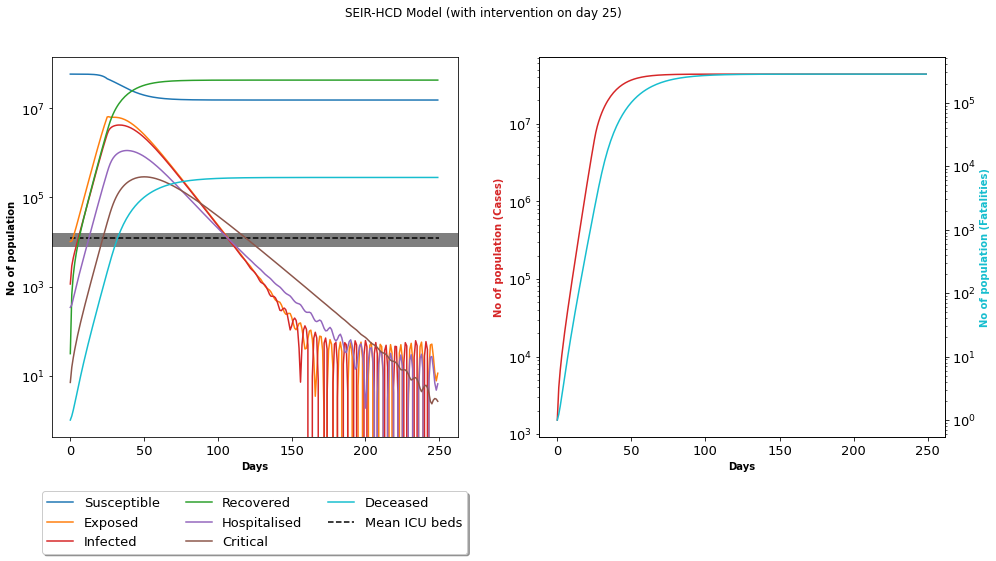

In [229]:
MyResultMidas2 = model_with_intervention(Midas_model,DaysToPredict,MyCountry, SADict,LockDown)
plot_model(MyResultMidas2,SADict["N"], SAHospital,f"SEIR-HCD Model (with intervention on day {LockDown})")

print(f"Maximum fatalities = {np.max(MyResultMidas2.y[-1])*SADict['N']:.3}")


max_dead = timedelta(**{'days': int(np.gradient(MyResultMidas2.y[-1]).argmax())})
print(f"Maximum starts to occur at {(datetime.strptime(MyDate, '%Y-%m-%d')+timedelta(days=max_dead.days)).strftime('%Y-%m-%d')}")


Not doing my country..this is for cross checking
Maximum fatalities = 3.66e+05
Maximum starts to occur at 2020-08-15


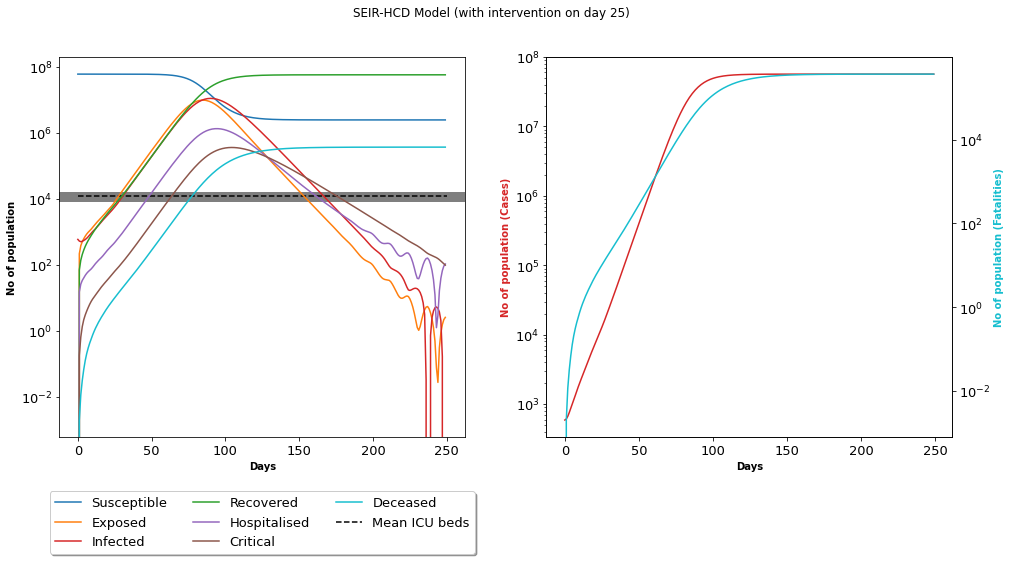

In [294]:
MyResultSA2 = model_with_intervention(SA_model,DaysToPredict,'lala', SADict, LockDown)
plot_model(MyResultSA2,SADict["N"], SAHospital,f"SEIR-HCD Model (with intervention on day {LockDown})")

print(f"Maximum fatalities = {np.max(MyResultSA2.y[-1])*SADict['N']:.3}")

max_dead = timedelta(**{'days': int(np.gradient(MyResultSA2.y[-1]).argmax())})
print(f"Maximum starts to occur at {(datetime.strptime(MyDate, '%Y-%m-%d')+timedelta(days=max_dead.days)).strftime('%Y-%m-%d')}")


# Comparison of the two cases

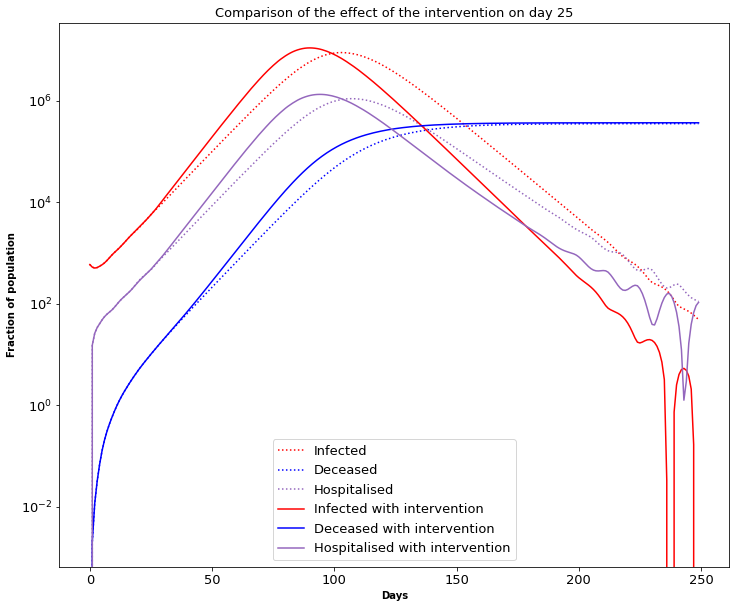

In [295]:
sus, exp, inf, rec, hosp, crit, deaths = MyResultSA.y
sus2, exp2, inf2, rec2, hosp2, crit2, deaths2 = MyResultSA2.y

#f = plt.figure(figsize=(8,5)) 
# plt.plot(exp, 'tab:orange', label='Exposed', linestyle=':');
plt.plot(inf*SADict['N'], 'r', label='Infected', linestyle=':');
plt.plot(deaths*SADict['N'], 'b', label='Deceased', linestyle=':');
plt.plot(hosp*SADict['N'], 'tab:purple', label='Hospitalised', linestyle=':');
# plt.plot(exp2, 'tab:orange', label='Exposed with intervention');
plt.plot(inf2*SADict['N'], 'r', label='Infected with intervention');
plt.plot(deaths2*SADict['N'], 'b', label='Deceased with intervention');
plt.plot(hosp2*SADict['N'], 'tab:purple', label='Hospitalised with intervention');
plt.semilogy()
plt.title(f'Comparison of the effect of the intervention on day {LockDown}')
plt.xlabel("Days", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best');

Fitting the model to data
There are certain variables that we can play with to fit the model to real data:

* Average incubation period, t_inc
* Average infection period, t_inf
* Average hospitalization period, t_hosp
* Average critital period, t_crit
* The fraction of mild/asymptomatic cases, m_a
* The fraction of severe cases that turn critical, c_a
* The fraction of critical cases that result in a fatality, f_a
* Reproduction number, R_0 or R_t

The some of these are likely to be constants specific to the virus and some are likely to be time dependent variables dependent on factors such as:

* When a government intervened
* Peoples behaviours (do people actively self-isolate, not visit religious shrines etc.)
* Population demographic of a country (is a significant proportion of the population old?). This is the a subscript
* Heathcare system capacity (hostpital beds per capita)
* Number of testing kits available

We have already used two different reproduction numbers above. Let's see if we can derive a time-dependent R_t from the data. We will also try and optimize a handful of the parameters above to match the data.

We will also compare this to just using a single reproduction number. This might actaully be more suitable in countries where the outbreak has just started or they are struggling to limit the spread.

There are lots of ways to decay a parameter in epidemiology. I'm going to use a Hill decay, which has 2 parameters, k and L (the half decay constant):

In [234]:
#Image(url= "https://raw.githubusercontent.com/wiki/SwissTPH/openmalaria/img/graphs/decay-functions.png")

# Checking the difference between the data and the model for infected

In [235]:
SAProvinConfirmed.index[0],SAProvinConfirmed.index[-1] 

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-05-05 00:00:00'))

In [85]:
#
# Recommend to use lockdown as the initial date
#
DateToStartModel = input('Date for start of projection YYYY-MM-DD: ')

Date for start of projection YYYY-MM-DD: 2020-03-27


In [86]:
tmp = df[(df['DateReported'] == DateToStartModel)]# & (df['Country/Region' == 'South Africa'])]

In [87]:
tmpSA = tmp[tmp['Country/Region'] == 'South Africa']

In [236]:
#
# Creating a dictionary to hold data for country selected
#
SADict = {
    "N" : SAPopulation,  # Population size
    "n_confirmed" : tmpSA['Confirmed'][0],
    "n_recovered" : tmpSA['Recovered'][1],
    "n_dead" : tmpSA['Dead'][2],
    "n_infected" : tmpSA['Confirmed'][0]-tmpSA['Recovered'][1],
    "n_exposed" : (tmpSA['Confirmed'][0]-tmpSA['Recovered'][1])*9 ,#thumbsuck
    "n_hosp" : 411,#from net as at 02-05-2020
    "n_crit" : 7
}

In [237]:
SADict

{'N': 59156682,
 'n_confirmed': 1170.0,
 'n_recovered': 31.0,
 'n_dead': 1.0,
 'n_infected': 1139.0,
 'n_exposed': 10251.0,
 'n_hosp': 411,
 'n_crit': 7}

In [238]:
LockDown = datetime.strptime(DateToStartModel, "%Y-%m-%d") - datetime.strptime(DateLockDownStart, "%Y-%m-%d")

In [239]:
SA_model

{'R_0': 2.773194762194605,
 'R_t': 1.4,
 't_inc': 5.1,
 't_inf': 6.5,
 't_hosp': 4,
 't_crit': 14,
 'm_a': 0.8,
 'c_a': 0.1,
 'f_a': 0.3}

In [240]:
WithLock = False

In [241]:
#
# we will use a lock down of 20 days
#
if WithLock:
    MyResultImperial2 = model_with_intervention(Imperial_model,DaysToPredict,MyCountry, SADict,np.abs(LockDown.days))
    MyResultMidas2 = model_with_intervention(Midas_model,DaysToPredict,MyCountry, SADict,np.abs(LockDown.days))
    MyResultSA2 = model_with_intervention(SA_model,DaysToPredict,MyCountry, SADict,np.abs(LockDown.days))
else:
    MyResultImperial2 = model_no_intervention(Imperial_model,DaysToPredict,MyCountry, SADict)
    MyResultMidas2 = model_no_intervention(Midas_model,DaysToPredict,MyCountry, SADict)
    MyResultSA2 = model_no_intervention(SA_model,DaysToPredict,MyCountry, SADict)

In [242]:
SAInfectModelImp2 = MyResultImperial2.y[2]*SADict["N"]
SAInfectModelMidas2 = MyResultMidas2.y[2]*SADict["N"]
SAInfectModelSA2 = MyResultSA2.y[2]*SADict["N"]

In [243]:
#
# Here selecting data from date model starts
#
SAInfectData=SAProvinConfirmed['Confirmed'][DateToStartModel:SAProvinConfirmed.index[-1]].values


In [244]:
ResidualModelDataImp2 = SAInfectModelImp2[0:len(SAInfectData)]-SAInfectData
ResidualModelDataMidas2 = SAInfectModelMidas2[0:len(SAInfectData)]-SAInfectData
ResidualModelDataSA2 = SAInfectModelSA2[0:len(SAInfectData)]-SAInfectData

ResidualSumSquare = [np.sum(np.square(ResidualModelDataImp2)),
                     np.sum(np.square(ResidualModelDataMidas2)),
                    np.sum(np.square(ResidualModelDataSA2))]

In [245]:
Model = ['Imperial', 'Midas','SA']

In [246]:
print(f"RSS = {np.argmin(ResidualSumSquare), min(ResidualSumSquare)}")
print(f"Best model for now is {Model[np.argmin(ResidualSumSquare)]}")

RSS = (2, 584425220205.9993)
Best model for now is SA


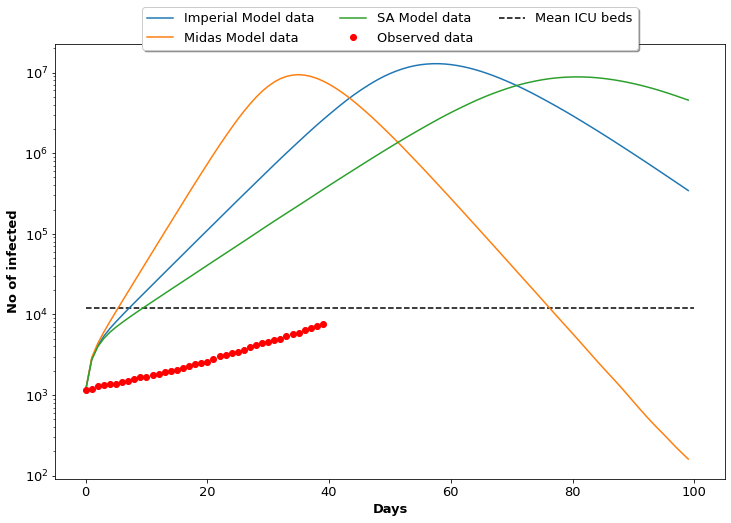

In [247]:
#
# Here I will plot the same number of days
#
plt.figure(figsize=(12,8))
plt.plot(SAInfectModelImp2[0:len(SAInfectData)+60],label="Imperial Model data")
plt.plot(SAInfectModelMidas2[0:len(SAInfectData)+60],label="Midas Model data")
plt.plot(SAInfectModelSA2[0:len(SAInfectData)+60],label="SA Model data")
plt.plot(SAInfectData,'ro',label="Observed data")
plt.hlines(MeanTotalBed,0,len(SAInfectData)+60,linestyles='dashed',label="Mean ICU beds")
plt.xlabel("Days")
plt.ylabel("No of infected")
plt.semilogy()

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),ncol=3, fancybox=True, shadow=True);

In [100]:
# Trying to loop for optimal R_0


# Checking the difference between the data and the model for infected

In [248]:
SAProvinConfirmed.index[0],SAProvinConfirmed.index[-1] 

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-05-05 00:00:00'))

In [249]:
#DateToStartModel = input('Date for start of projection YYYY-MM-DD: ')

In [250]:
tmp = df[(df['DateReported'] == DateToStartModel)]# & (df['Country/Region' == 'South Africa'])]

In [251]:
tmpSA = tmp[tmp['Country/Region'] == 'South Africa']

In [252]:
LockDown = datetime.strptime(DateToStartModel, "%Y-%m-%d") - datetime.strptime(DateLockDownStart, "%Y-%m-%d")

In [253]:
#
# Creating a dictionary to hold data for country selected
#
SADict = {
    "N" : SAPopulation,  # Population size
    "n_confirmed" : tmpSA['Confirmed'][0],
    "n_recovered" : tmpSA['Recovered'][1],
    "n_dead" : tmpSA['Dead'][2],
    "n_infected" : tmpSA['Confirmed'][0]-tmpSA['Recovered'][1],
    "n_exposed" : (tmpSA['Confirmed'][0]-tmpSA['Recovered'][1])*9 ,#thumbsuck
    "n_hosp" : 411,
    "n_crit" : 7
}



In [254]:
WithLock = False

In [255]:
Imperial_model

{'R_0': 4.0,
 'R_t': 1.6100000000000003,
 't_inc': 5.1,
 't_inf': 6.5,
 't_hosp': 4,
 't_crit': 14,
 'm_a': 0.8,
 'c_a': 0.1,
 'f_a': 0.3}

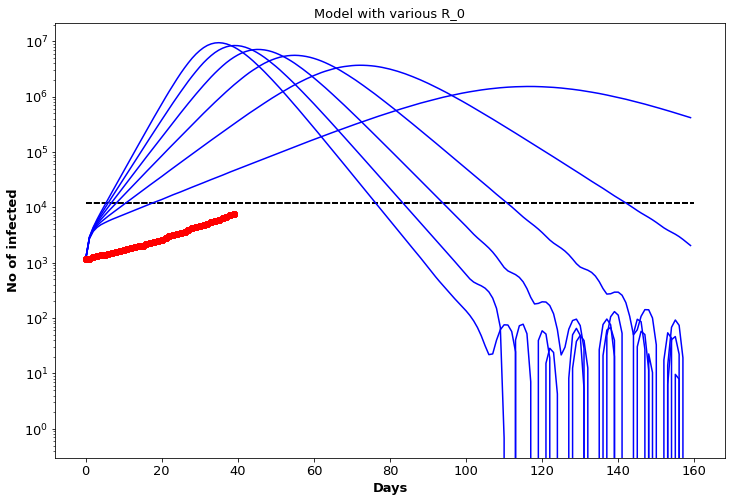

In [256]:
plt.figure(figsize=(12,8))
RSS = []
for R_0 in np.arange(1.5,4.5,0.5):
    SA_model['R_0'] = R_0
    Imperial_model['R_0'] = R_0
    Midas_model['R_0'] = R_0
    #
    # we will use a lock down of 20 days
    #
    if WithLock:
        MyResultImperial2 = model_with_intervention(Imperial_model,DaysToPredict,MyCountry, SADict,np.abs(LockDown.days))
        MyResultMidas2 = model_with_intervention(Midas_model,DaysToPredict,MyCountry, SADict,np.abs(LockDown.days))
        MyResultSA2 = model_with_intervention(SA_model,DaysToPredict,MyCountry, SADict,np.abs(LockDown.days))
    else:
        MyResultImperial2 = model_no_intervention(Imperial_model,DaysToPredict,MyCountry, SADict)
        MyResultMidas2 = model_no_intervention(Midas_model,DaysToPredict,MyCountry, SADict)
        MyResultSA2 = model_no_intervention(SA_model,DaysToPredict,MyCountry, SADict)
   
    #print(Midas_model)
 
    SAInfectModelImp2 = MyResultImperial2.y[2]*SADict["N"]
    SAInfectModelMidas2 = MyResultMidas2.y[2]*SADict["N"]
    SAInfectModelSA2 = MyResultSA2.y[2]*SADict["N"]

    #
    # Here selecting data from date model starts
    #
    SAInfectData=SAProvinConfirmed['Confirmed'][DateToStartModel:SAProvinConfirmed.index[-1]].values


    ResidualModelDataImp2 = SAInfectModelImp2[0:len(SAInfectData)]-SAInfectData
    ResidualModelDataMidas2 = SAInfectModelMidas2[0:len(SAInfectData)]-SAInfectData
    ResidualModelDataSA2 = SAInfectModelSA2[0:len(SAInfectData)]-SAInfectData

    ResidualSumSquare = [np.sum(np.square(ResidualModelDataImp2)),
                         np.sum(np.square(ResidualModelDataMidas2)),
                        np.sum(np.square(ResidualModelDataSA2))]

    Model = ['Imperial', 'Midas','SA']
    
    #print(f"RSS = {np.argmin(ResidualSumSquare), min(ResidualSumSquare)}")
    #print(f"Best model for now is {Model[np.argmin(ResidualSumSquare)]}, with {min(ResidualSumSquare)}")
    RSS.append((R_0,ResidualSumSquare))
    #
    # Here I will plot the same number of days
    #

    #plt.plot(SAInfectModelImp2[0:len(SAInfectData)+120],'r',label=f"R_0={R_0}")
    plt.plot(SAInfectModelMidas2[0:len(SAInfectData)+120],'b',label="Midas Model data")
    #plt.plot(SAInfectModelSA2[0:len(SAInfectData)+120],'g',label="SA Model data")
    plt.semilogy()
    
    plt.plot(SAInfectData,'ro',label="Observed data")
    plt.hlines(MeanTotalBed,0,len(SAInfectData)+120,linestyles='dashed',label="Mean ICU beds")
    plt.xlabel("Days")
    plt.ylabel("No of infected")
    plt.title(f"Model with various R_0")
#plt.legend(loc='best')#, bbox_to_anchor=(0.5, 1.1),ncol=3, fancybox=True, shadow=True);
#plt.show()


In [257]:
RSSDf = pd.DataFrame(RSS, columns={"R_0","RSS_value"})

In [258]:
RSSDf['RSS_value'].values

array([list([3917233200.4825892, 12221418170.817936, 3917233200.4825892]),
       list([34279539095.48928, 479624400009.13135, 34279539095.48928]),
       list([226119412388.87775, 10366089182097.254, 226119412388.87775]),
       list([1243210309875.776, 110701699249842.72, 1243210309875.776]),
       list([5949860698743.216, 447849196041978.25, 5949860698743.216]),
       list([24786696652304.867, 831775304474754.1, 24786696652304.867])],
      dtype=object)

# Using a simple SIRD model 

In [107]:
def derivSIRD(y, t, N, beta, gamma, mu):
    '''
    y - inital values
    beta, gamme and mu are the rates of infection, recovery and mortality
    
    '''
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I - mu * I
    dRdt = gamma * I
    dDdt = mu * I
    return dSdt, dIdt, dRdt, dDdt

In [108]:
from scipy.integrate import odeint

In [109]:
MyStartDate = '2020-03-27'

In [110]:
# Adding death numbers to the second model for SIR starting about 3/21
I0 = ConfirmedDf.Confirmed[(ConfirmedDf['Country/Region']=='South Africa') 
                           & (ConfirmedDf.index == MyStartDate)].values[0]
R0 = RecoveredDf.Recovered[(RecoveredDf['Country/Region']=='South Africa') 
                           & (RecoveredDf.index == MyStartDate)].values[0]
D0 = DeadDf.Dead[(DeadDf['Country/Region']=='South Africa') 
                           & (DeadDf.index == MyStartDate)].values[0]

S0 = SADict['N'] - I0 - R0 - D0

t = np.linspace(0,180, 180)

beta, gamma = 0.54, 0.032  
mu = 0.012

y0 = S0, I0, R0, D0
ret = odeint(derivSIRD, y0, t, args =(SADict['N'], beta, gamma, mu))

S, I, R, D = ret.T

[]

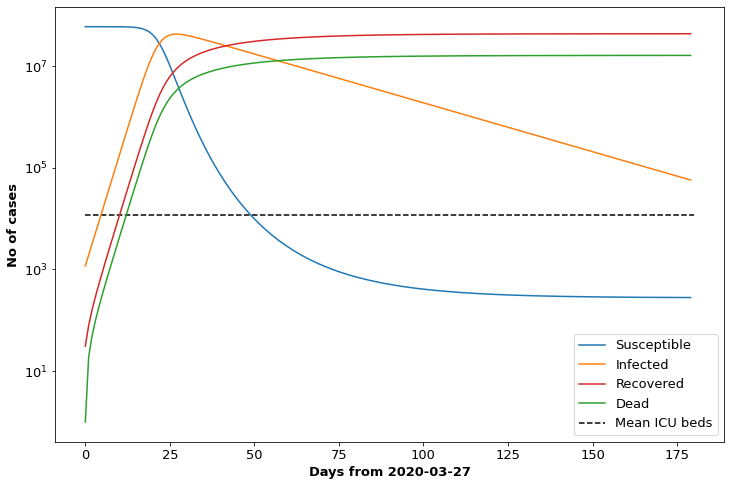

In [111]:
plt.figure(figsize=(12,8))

#fig.suptitle(title)

plt.plot(S, 'tab:blue', label='Susceptible');
plt.plot(I, 'tab:orange', label='Infected');
plt.plot(R, 'tab:red', label='Recovered');
plt.plot(D, 'tab:green', label='Dead');
plt.xlabel(f"Days from {MyStartDate}")
plt.ylabel("No of cases")
plt.hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(S),linestyles='dashed',
           label="Mean ICU beds")
plt.legend()
plt.semilogy()

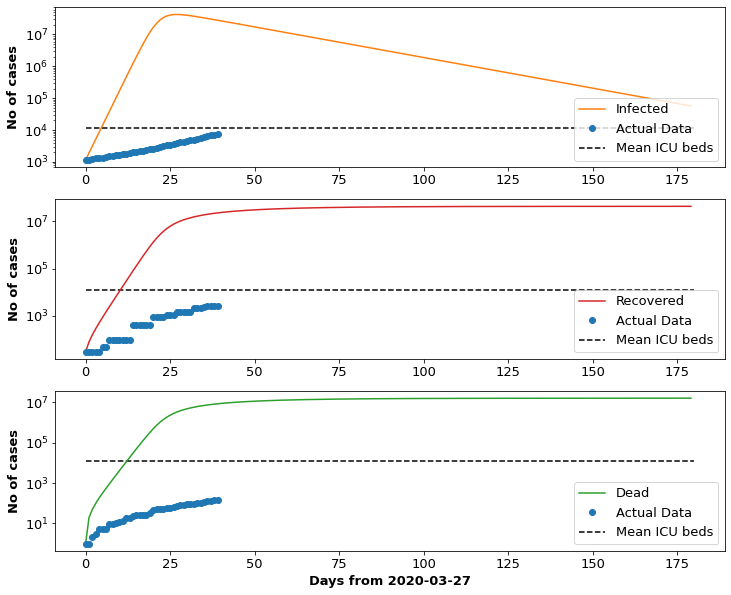

In [113]:
fig, ax = plt.subplots(3,1)
                                
ax[0].plot(I, 'tab:orange', label='Infected');
ax[0].plot(ConfirmedDf.Confirmed[(ConfirmedDf['Country/Region']=='South Africa') 
                               & (ConfirmedDf.index >= MyStartDate)].values,'o',label='Actual Data');
ax[0].hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(S),linestyles='dashed',
           label="Mean ICU beds")
ax[0].set_ylabel("No of cases")
ax[0].semilogy()
ax[0].legend(loc='lower right')

ax[1].plot(R, 'tab:red', label='Recovered');
ax[1].plot(RecoveredDf.Recovered[(RecoveredDf['Country/Region']=='South Africa') 
                               & (RecoveredDf.index >= MyStartDate)].values,'o',label='Actual Data');
ax[1].hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(R),linestyles='dashed',
           label="Mean ICU beds")
ax[1].set_ylabel("No of cases")
ax[1].semilogy()
ax[1].legend(loc='lower right')

ax[2].plot(D, 'tab:green', label='Dead');
ax[2].plot(DeadDf.Dead[(DeadDf['Country/Region']=='South Africa') 
                               & (DeadDf.index >= MyStartDate)].values,'o',label='Actual Data');
ax[2].hlines(np.mean([SAHospital[1][0],SAHospital[1][1]]),0,len(D),linestyles='dashed',
           label="Mean ICU beds")
ax[2].set_ylabel("No of cases")
ax[2].semilogy()
ax[2].legend(loc='lower right')

plt.xlabel(f"Days from {MyStartDate}");
